In [ ]:
pip install transformers datasets


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd

df_test= pd.read_csv("https://raw.githubusercontent.com/Wajihboukhdhir/tweet-corona-classification/refs/heads/main/Corona_NLP_test.csv",encoding="ISO-8859-1")
print(df_test.head())

df_train= pd.read_csv("https://raw.githubusercontent.com/Wajihboukhdhir/tweet-corona-classification/refs/heads/main/Corona_NLP_train.csv",encoding="ISO-8859-1")
print(df_train.head())

/kaggle/input/corona-nlp/Corona_NLP_test.csv
/kaggle/input/corona-nlp/Corona_NLP_train.csv
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


In [ ]:
columns_to_remove = ['UserName', 'ScreenName',"TweetAt","Location"]
df_train = df_train.drop(columns=columns_to_remove)
df_test = df_test.drop(columns=columns_to_remove)

In [ ]:
df_train["Rating"] = df_train.Sentiment.map({
    "Extremely Positive" : 2,
    "Positive" : 2,
    "Neutral" : 1,
    "Negative":0,
    "Extremely Negative":0
})
df_test["Rating"] = df_test.Sentiment.map({
    "Extremely Positive" : 2,
    "Positive" : 2,
    "Neutral" : 1,
    "Negative":0,
    "Extremely Negative":0
})
print(df_train.head())

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   

   Rating  
0       1  
1       2  
2       2  
3       2  
4       0  


In [ ]:
import re
import html
import emoji

# Function to remove emojis
def strip_emoji(text):
    return emoji.replace_emoji(text, "") if hasattr(emoji, 'replace_emoji') else text

# Function to filter out words with special characters like '$' and '&'
def filter_chars(text):
    sent = []
    for word in text.split(' '):
        if ('$' in word) or ('&' in word):
            sent.append('')  # Remove words containing '$' or '&'
        else:
            sent.append(word)
    return ' '.join(sent)

# Function to remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)

# Main data cleaner function
def data_cleaner(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', ' ', tweet)

    # Remove HTML tags
    tweet = re.sub(r'<.*?>', ' ', tweet)

    # Remove digits
    tweet = re.sub(r'\d+', ' ', tweet)

    # Remove hashtags
    tweet = re.sub(r'#\w+', ' ', tweet)

    # Remove mentions
    tweet = re.sub(r'@\w+', ' ', tweet)

    # Remove HTML entities (like &gt;, &lt;, etc.)
    tweet = html.unescape(tweet)

    # Remove emojis
    tweet = strip_emoji(tweet)

    # Filter out words with special characters like '$' and '&'
    tweet = filter_chars(tweet)

    # Remove multiple spaces
    tweet = remove_mult_spaces(tweet)

    # Clean up extra spaces
    tweet = tweet.strip()

    return tweet


# Apply the function to the data
df_train["OriginalTweet"] = df_train["OriginalTweet"].apply(data_cleaner)
df_test["OriginalTweet"] = df_test["OriginalTweet"].apply(data_cleaner)


In [ ]:
# Remove rows where the length of "OriginalTweet" is zero in df_train and df_test
df_train = df_train[df_train["OriginalTweet"].str.len() > 0]
df_test = df_test[df_test["OriginalTweet"].str.len() > 0]

In [ ]:
X_train = df_train["OriginalTweet"]
y_train = df_train["Rating"]
X_test = df_test["OriginalTweet"]
y_test = df_test["Rating"]

In [ ]:
longest_tweet_index = X_train.apply(len).idxmax()

# Retrieve the longest tweet
longest_tweet = X_train.loc[longest_tweet_index]

# Print the longest tweet
print(f"The longest tweet is: {longest_tweet}")
print(f"Length of the longest tweet: {len(longest_tweet)} characters")
print(longest_tweet_index)

The longest tweet is: MDOC Horhn MS MS brown MISSISSIPPI PRISONERS ARE GOING ON OFFICIAL FOOD amp WATER STRIKE APRIL TO PROTEST THE COVID PANDEMIC amp LACK OF PREVENTENTIVE MEASURES TAKEN BY MDOC STAFF SHORTAGE INHUMANE LIVING CONDITIONS POOR FOOD QUALITY QUALITY ABUSE amp DEMAND MSLEG FINALIZE amp ENACT SB
Length of the longest tweet: 286 characters
35866


In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(df_train["OriginalTweet"]).reshape(-1, 1), np.array(df_train["Rating"]).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train],  y_train)), columns = ['OriginalTweet', 'Rating']);

In [ ]:
train_os['Rating'].value_counts()


Rating
1    18046
2    18046
0    18046
Name: count, dtype: int64

In [ ]:
X_train = train_os["OriginalTweet"]
y_train = train_os["Rating"]

In [ ]:
# Step 1: Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Step 2: Vectorize the Text Data using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)  # Fit and transform the training data
X_test_tfidf = tfidf_vectorizer.transform(X_test)  # Transform the test data

# Step 3: Train a Naive Bayes Model
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tfidf, y_train)  # Fit the model on the training data

# Step 4: Make Predictions on the Test Set
y_pred = naive_bayes.predict(X_test_tfidf)

# Step 5: Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['0', '1', '2']))


Accuracy: 0.6979989468141127
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.72      0.73      1633
           1       0.51      0.64      0.57       619
           2       0.76      0.70      0.73      1546

    accuracy                           0.70      3798
   macro avg       0.67      0.69      0.67      3798
weighted avg       0.71      0.70      0.70      3798



In [ ]:
#pip install transformers tensorflow


In [ ]:
import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer


In [ ]:
from transformers import AutoTokenizer  # Importing AutoTokenizer from Hugging Face's transformers library

# Initialize the tokenizer (replace 'bert-base-uncased' with your model of choice)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# This initializes the tokenizer for the BERT model 'bert-base-uncased'. This tokenizer will convert text into input IDs and attention masks that are required for BERT.

def tokenize(data):  # Define a function 'tokenize' that takes in the 'data' (a list of text strings)
    input_ids = []  # Initialize an empty list to store the input IDs for each text
    attention_masks = []  # Initialize an empty list to store the attention masks for each text

    for i in range(len(data)):  # Loop through the 'data' (list of text strings)
        # Use the tokenizer to encode each text
        encoded = tokenizer.encode_plus(
            data[i],  # The input text string to be tokenized (data[i] is the i-th string from the data)
            add_special_tokens=True,  # Add special tokens like [CLS] and [SEP] as required by BERT
            max_length=128,  # Set the maximum length of the input sequences to 128 tokens
            padding='max_length',  # Pad the sequences to the max_length (128 in this case)
            return_attention_mask=True,  # Also return an attention mask (which helps the model ignore padded tokens)
            truncation=True  # Truncate the sequences if they are longer than 128 tokens
        )

        # Append the encoded input IDs and attention masks to their respective lists
        input_ids.append(encoded['input_ids'])  # 'encoded' is a dictionary, and 'input_ids' is the tokenized representation of the text
        attention_masks.append(encoded['attention_mask'])  # The attention mask indicates which tokens should be attended to (1 for real tokens, 0 for padding)

    return np.array(input_ids), np.array(attention_masks)  # Convert the lists of input IDs and attention masks to numpy arrays and return them


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Ensure the data is in string format
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Tokenizing the data
train_input_ids, train_attention_masks = tokenize(X_train.tolist())
val_input_ids, val_attention_masks = tokenize(X_test.tolist())

# Check shapes
print(f"Train input IDs shape: {train_input_ids.shape}")
print(f"Train attention masks shape: {train_attention_masks.shape}")
print(f"Validation input IDs shape: {val_input_ids.shape}")
print(f"Validation attention masks shape: {val_attention_masks.shape}")


Train input IDs shape: (54138, 128)
Train attention masks shape: (54138, 128)
Validation input IDs shape: (3798, 128)
Validation attention masks shape: (3798, 128)


In [ ]:
def create_model(bert_model, max_len):
    ## Parameters ###
    # Define the optimizer. Here, Adam optimizer is used with a very small learning rate and decay (regularization)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    # Define the loss function. SparseCategoricalCrossentropy is used for classification problems with integer labels.
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    # Define the metric to be used during evaluation. SparseCategoricalAccuracy is appropriate for classification tasks with integer labels.
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Input layers:
    # Define the input layer for input_ids. It accepts an input of shape (max_len,), where max_len is the maximum length of tokenized text.
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    # Define the input layer for attention_masks. It also accepts an input of shape (max_len,) for the attention mask.
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # BERT embeddings:
    # Use the BERT model to get the embeddings. The model expects both input_ids and attention_masks.
    # The [1] at the end is used to extract the second output from the BERT model, which is typically the embeddings.
    embeddings = bert_model([input_ids, attention_masks])[1]

    # Output layer:
    # After obtaining the embeddings from BERT, pass them through a dense layer.
    # The dense layer has 3 units and uses a softmax activation to output probabilities for 3 classes.
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    # Define model:
    # Use the functional API to define the model, specifying both input layers and the output layer.
    # The model takes input_ids and attention_masks as inputs, and outputs the class probabilities from the output layer.
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compile the model:
    # Compile the model with the Adam optimizer, SparseCategoricalCrossentropy loss function, and SparseCategoricalAccuracy metric.
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model


In [ ]:
# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Create and summarize the model
model = create_model(bert_model, 128)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_5[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_6[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [ ]:
# Train the model (use 20% of the training data for validation)
history_bert = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=4,
    batch_size=32
)


Epoch 1/4
1354/1354 [==============================] - 1131s 835ms/step - loss: 0.4643 - sparse_categorical_accuracy: 0.8239 - val_loss: 0.4690 - val_sparse_categorical_accuracy: 0.8457
Epoch 2/4
1354/1354 [==============================] - 1127s 832ms/step - loss: 0.2524 - sparse_categorical_accuracy: 0.9132 - val_loss: 0.2888 - val_sparse_categorical_accuracy: 0.8870
Epoch 3/4
1354/1354 [==============================] - 1126s 832ms/step - loss: 0.1723 - sparse_categorical_accuracy: 0.9438 - val_loss: 0.2157 - val_sparse_categorical_accuracy: 0.8979
Epoch 4/4
1354/1354 [==============================] - 1127s 832ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.9573 - val_loss: 0.2090 - val_sparse_categorical_accuracy: 0.9043


In [ ]:
# Evaluate the model on the reserved validation data
test_loss, test_accuracy = model.evaluate([val_input_ids, val_attention_masks], y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

119/119 [==============================] - 32s 265ms/step - loss: 0.2597 - sparse_categorical_accuracy: 0.9157
Test Loss: 0.25969305634498596
Test Accuracy: 0.9157451391220093


119/119 [==============================] - 32s 268ms/step


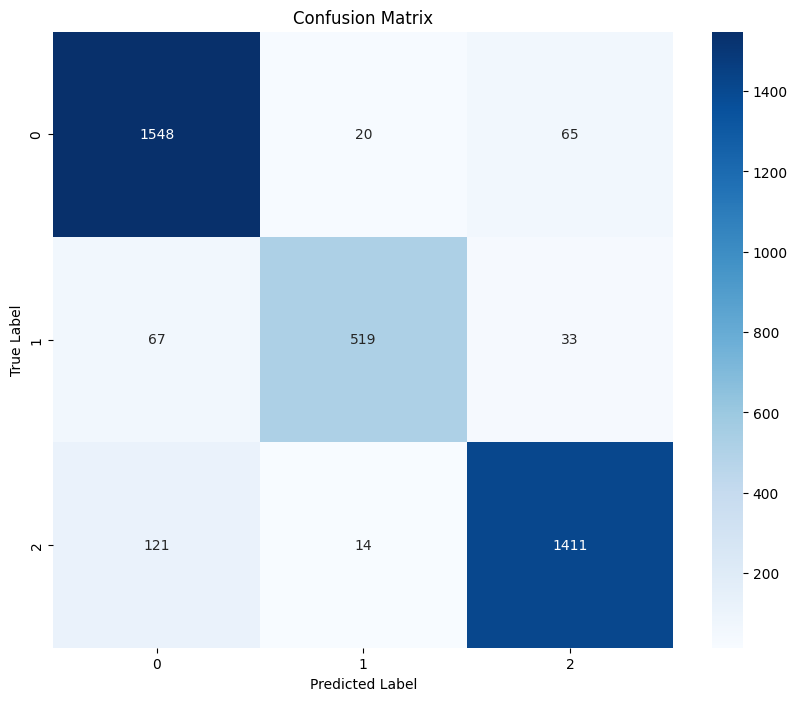

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1633
           1       0.94      0.84      0.89       619
           2       0.94      0.91      0.92      1546

    accuracy                           0.92      3798
   macro avg       0.92      0.90      0.91      3798
weighted avg       0.92      0.92      0.92      3798



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# If y_test contains the class indices
class_names = [str(label) for label in np.unique(y_test)]

# Step 1: Predict the classes on the test set
y_pred_probs = model.predict([val_input_ids, val_attention_masks])  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels (assuming multi-class classification)

# Step 2: Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 4: Print the classification report (optional)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))
